# [Allstate](https://bit.ly/2Qdfxkf)


### Celem tej lekcji jest oszacowanie wysokości odszkodowania z tytułu ubezpieczenia.

In [2]:
import helper as h

import importlib
importlib.reload(h)

import pandas as pd
import numpy as np
np.random.seed(2019)

from sklearn.preprocessing import minmax_scale

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## Wczytujemy dane

In [3]:
train = pd.read_csv('../input/allstate.train.csv')

Jak zobaczymy poniżej, same nazwy zmiennych i ich wartości niewiele nam powiedzą. 

Wiemy tylko, że kolumny zaczynające się od `cat`, to zmienne kategorialne, a te zaczynające się od `cont` to zmienne ciągłe. Z kolei zmienną docelową jest `loss`.

In [4]:
train.info()
#train.info(max_cols=140)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [5]:
train.columns.values

array(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14',
       'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21',
       'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28',
       'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35',
       'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42',
       'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49',
       'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56',
       'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63',
       'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70',
       'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77',
       'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84',
       'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91',
       'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98',
       'cat99', 'cat100

In [6]:
train.sample(10)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
150091,468008,A,A,A,A,B,A,A,A,A,...,0.879507,0.856216,0.28768,0.64296,0.83510,0.784967,0.785706,0.837535,0.708622,2129.69
8652,27472,A,A,A,B,B,B,A,A,A,...,0.544630,0.425088,0.67787,0.79047,0.60932,0.592525,0.579845,0.723122,0.802008,8289.68
103918,324684,A,B,A,B,A,A,A,A,B,...,0.416181,0.349614,0.62918,0.50630,0.37493,0.338312,0.338446,0.315758,0.488121,4606.95
134811,420588,A,A,A,A,B,A,A,A,A,...,0.364464,0.365369,0.24564,0.32865,0.40666,0.245410,0.241676,0.624025,0.540100,4103.90
104982,327919,A,B,A,B,B,A,A,A,B,...,0.314430,0.251752,0.44697,0.42289,0.26029,0.192281,0.190178,0.470036,0.235522,2958.38
72648,227029,A,A,A,A,B,B,A,A,A,...,0.342167,0.291170,0.34987,0.31945,0.22755,0.275431,0.270746,0.503333,0.247853,2664.86
76605,239586,A,A,A,A,B,A,A,A,A,...,0.722158,0.591403,0.71817,0.64873,0.74396,0.698978,0.685713,0.689974,0.836878,1347.73
184432,575483,A,B,A,A,B,A,A,A,B,...,0.557431,0.402942,0.34445,0.52728,0.79139,0.377724,0.369858,0.687115,0.801539,3463.32
178171,555969,A,A,A,B,A,B,A,A,A,...,0.278408,0.308363,0.29260,0.24958,0.27777,0.180456,0.178698,0.310026,0.230296,1202.91
180802,564100,A,B,A,A,A,A,A,A,B,...,0.233692,0.244789,0.70342,0.30859,0.21230,0.197173,0.194925,0.417430,0.660063,2331.47


Usuńmy ID, bo będzie nam tylko przeszkadzać, a nie będzie nam potrzebne. 

In [7]:
if 'id' in train: del train['id']

## Target variable - `loss`

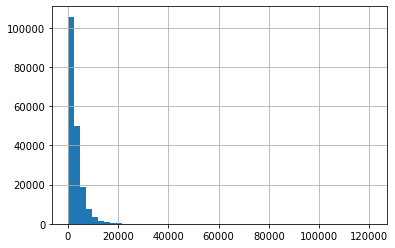

In [8]:
train['loss'].hist(bins=50);

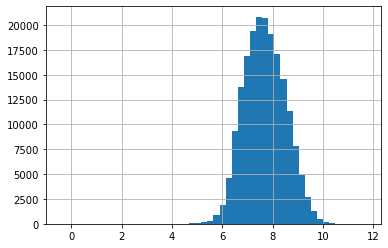

In [9]:
train['log_loss'] = np.log( train['loss'] )
train['log_loss'].hist(bins=50);

## Basic Model

In [10]:
X, y = train[ ['cont1'] ], train['loss'].values

model = DummyRegressor()
model.fit(X, y)
y_pred = model.predict(X)

mean_absolute_error(y, y_pred)

1966.1652855607203

## Basic Model++
Zbudujmy teraz trochę lepszy model - liniowy, bazując na wszystkich kolumnach numerycznych.

In [11]:
train.select_dtypes(include=[np.number]).columns.values

array(['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14',
       'loss', 'log_loss'], dtype=object)

Przygotujmy dwie funkcje:
- `get_feats()` zwraca cechy (w tym przypadku numeryczne i wyklucza `black_list`)
- `get_X_y()` - zwraca `X` oraz `y` jako `ndarray` (typ `numpy`)

In [12]:
def get_feats(df):
    black_list = ['loss', 'log_loss']
    feats = df.select_dtypes(include=[np.number]).columns.values
    
    feats = [feat for feat in feats if feat not in black_list]
    return feats
    
def get_X_y(df, target='loss', verbose=False):
    feats = get_feats(df)
    if verbose: print(feats)
        
    X = df[ get_feats(df) ].values
    y = df[target].values
    
    return X, y

X, y = get_X_y(train)

Przygotujmy kolejne dwie funkcje:
- `run_cv()` - funkcja do trenowanie modelu z walidacją krzyżową (`KFold`)
- `run_log_cv()`- funkcja do trenowanie modelu z walidacją krzyżową (`KFold`), w tym przypadku adaptowane do transformacji logistycznej (i odkręcanie z powrotem).

In [13]:
def run_cv(X, y, model, folds=3):
    cv = KFold(n_splits=folds, shuffle=True, random_state=0)

    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)


def run_log_cv(X, y, model, folds=3, shift = 1):
    y_log = np.log(y + shift)
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=0)

    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y_log[train_idx])
        y_log_pred = model.predict(X[test_idx])
        y_log_pred[ y_log_pred < 0 ] = 1e-6
        
        y_pred = np.exp( y_log_pred ) - shift

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)

In [14]:
run_cv(X, y, LinearRegression())

(1950.6093145182822, 5.26358554128088)

Liniowy model działa trochę lepiej niż `dummy`: **1966** vs **1950**.  

## Decision Tree & Random Forest & Extra Trees
Zastosujemy teraz bardziej złożone modele.

In [15]:
run_cv(X, y, DecisionTreeRegressor(max_depth=5))

(1937.9872302392566, 7.785759849308942)

In [16]:
run_cv(X, y, RandomForestRegressor(max_depth=5, n_estimators=20))

(1931.9824319465795, 5.043444168409942)

In [17]:
run_cv(X, y, ExtraTreesRegressor(max_depth=5, n_estimators=20))

(1936.8722319157778, 5.970205891156901)

DT/RF/ET dają trochę lepszy wynik niż model liniowy :).

Nadszedł czas na generowanie nowych cech. Na pierwszy ogień bierzemy zmienne kategorialne i używając `LabelEncoding` przypiszemy każdej unikalnej wartości własny ID.

## Feature Engineering

In [18]:
num_feats = [feat for feat in train.columns if 'cont' in feat]
cat_feats = [feat for feat in train.columns if 'cat' in feat]

cat_id_feats = []
for feat in tqdm(cat_feats):
    feat_id = feat + '_id'
    train[feat_id] = train[feat].factorize()[0]
    cat_id_feats.append(feat_id)

 79%|████████████████████████████████████████████████████████████████████████████▉                    | 92/116 [00:00<00:00, 101.32it/s]/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_54707/493797610.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[feat_id] = train[feat].factorize()[0]
/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykernel_54707/493797610.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[feat_id] = train[feat].factorize()[0]
/var/folders/00/3f1t2rhd45l6fvmbkz20ptgh00dr78/T/ipykern

In [19]:
X, y = get_X_y(train)

In [20]:
run_cv(X, y, DecisionTreeRegressor(max_depth=5))

(1455.0165712010548, 1.487663755276177)

Jak widać, zmienne kategorialne bardzo pomogły: ~**1936** vs ~**1455**.

## Cont variables
Popatrzmy teraz na zmienne ciągle, a następnie spróbujmy na kilka różnych sposób je połączyć.

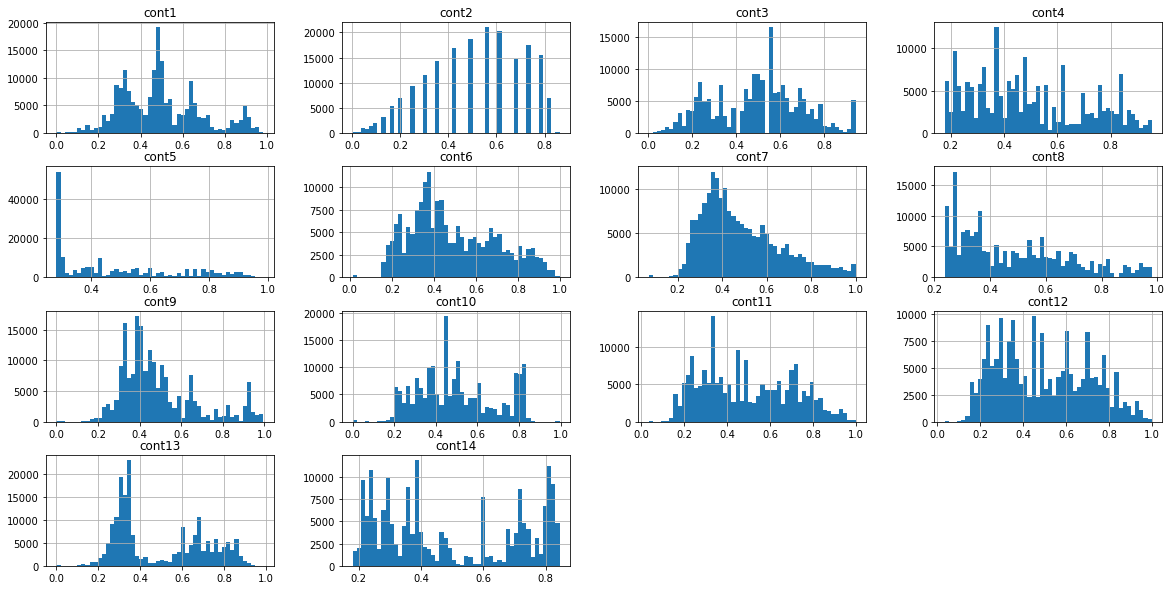

In [21]:
train[ num_feats ].hist(figsize=(20, 10), bins=50);

### Dodawanie
Zaczniemy od sumowania wybranych par.

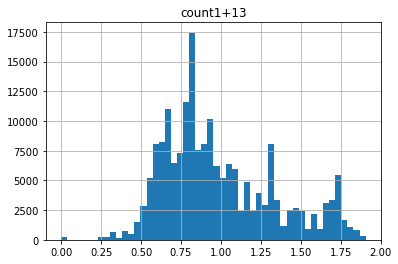

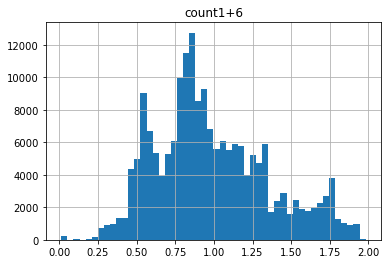

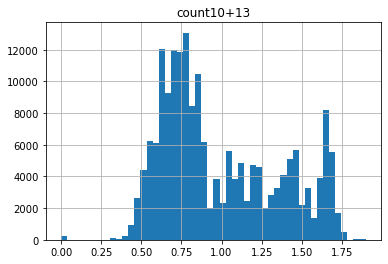

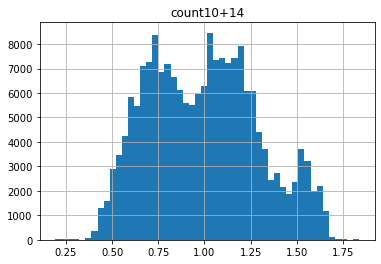

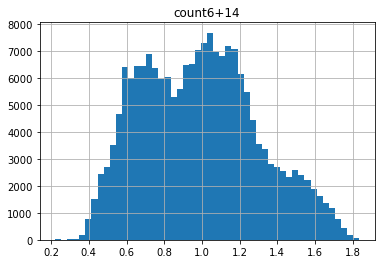

In [22]:
sum_pairs = [
    (1, 13),
    (1, 6),
    (10, 13),
    (10, 14),
    (6, 14),
]
sum_feats = []

for left, right in sum_pairs:
    output_idx = 'count{0}+{1}'.format(left, right)
    train[output_idx] = train['cont{0}'.format(left)] + train['cont{0}'.format(right)]
    sum_feats.append(output_idx)
    
    train[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

### Odejmowanie
Spróbujmy też odjąć jedną od drugiej.

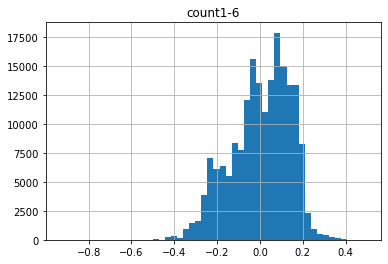

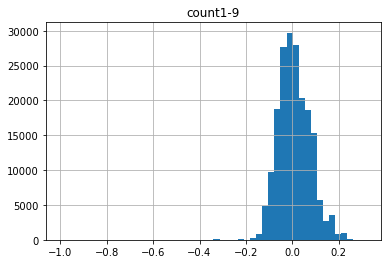

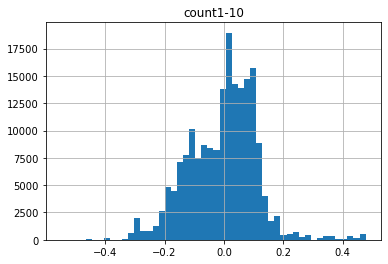

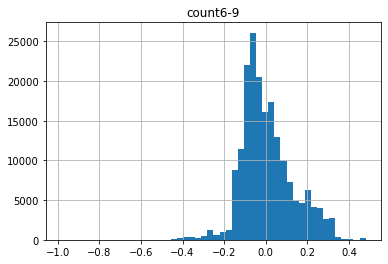

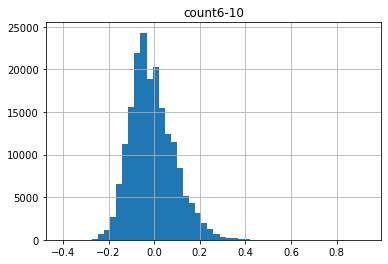

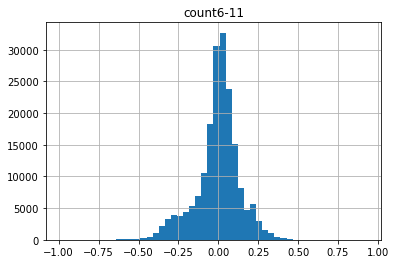

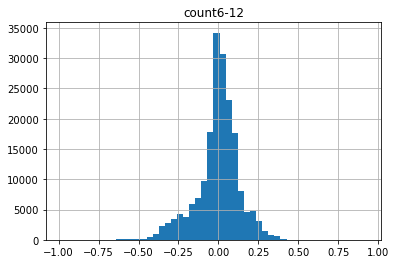

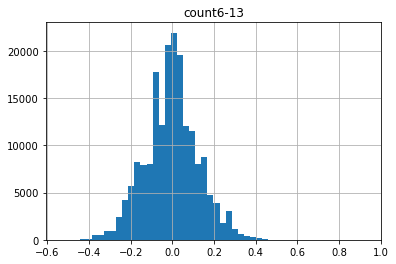

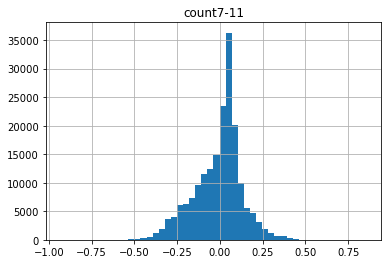

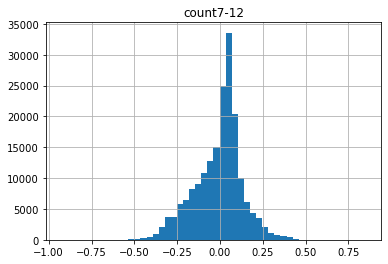

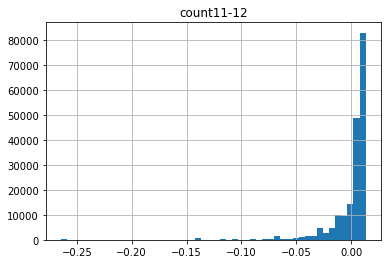

In [24]:
minus_pairs = [
    (1, 6),
    (1, 9),
    (1, 10),
    (6, 9),
    (6, 10),
    (6, 11),
    (6, 12),
    (6, 13),
    (7, 11),
    (7, 12),
    (11, 12)
]

minus_feats = []
for left, right in minus_pairs:
    output_idx = 'count{0}-{1}'.format(left, right)
    train[output_idx] = train['cont{0}'.format(left)] - train['cont{0}'.format(right)]
    minus_feats.append(output_idx)
    
    train[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

Niektóre wyglądają na ciekawe kombinacje :)

## Feature Importance
Sprawdzimy teraz ważność cech. 

Najpierw skupmy się na drzewach decyzyjnych:

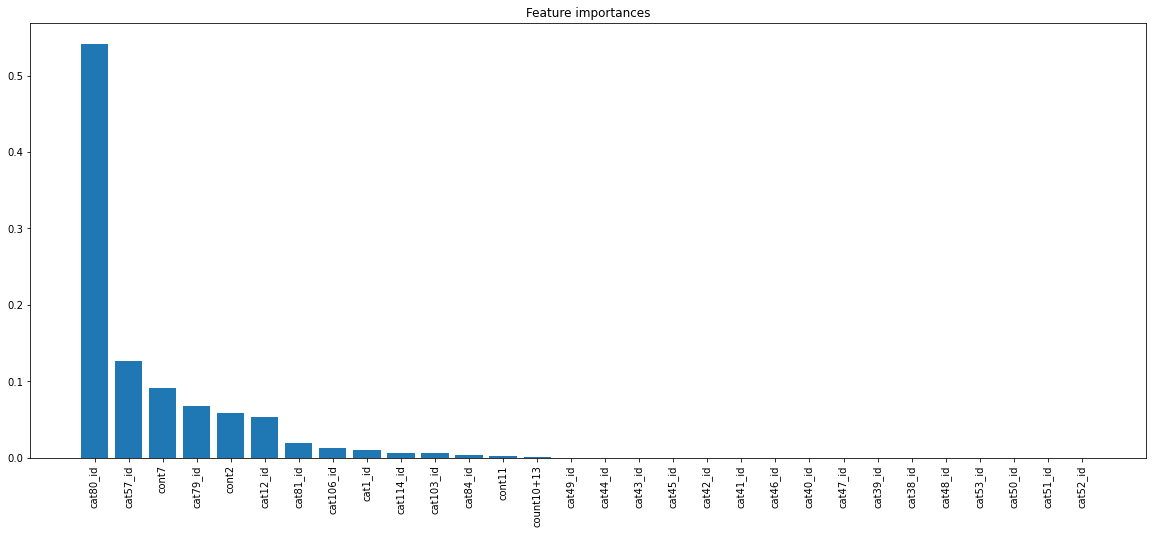

In [25]:
feats = cat_id_feats + num_feats + sum_feats + minus_feats
X = train[feats].values

model = DecisionTreeRegressor(max_depth=5)
model.fit(X, y)

h.plot_feature_importances(model, feats, limit=30)

## RandomForest
Sprawdźmy również ważność cech w przypadku lasów losowych:

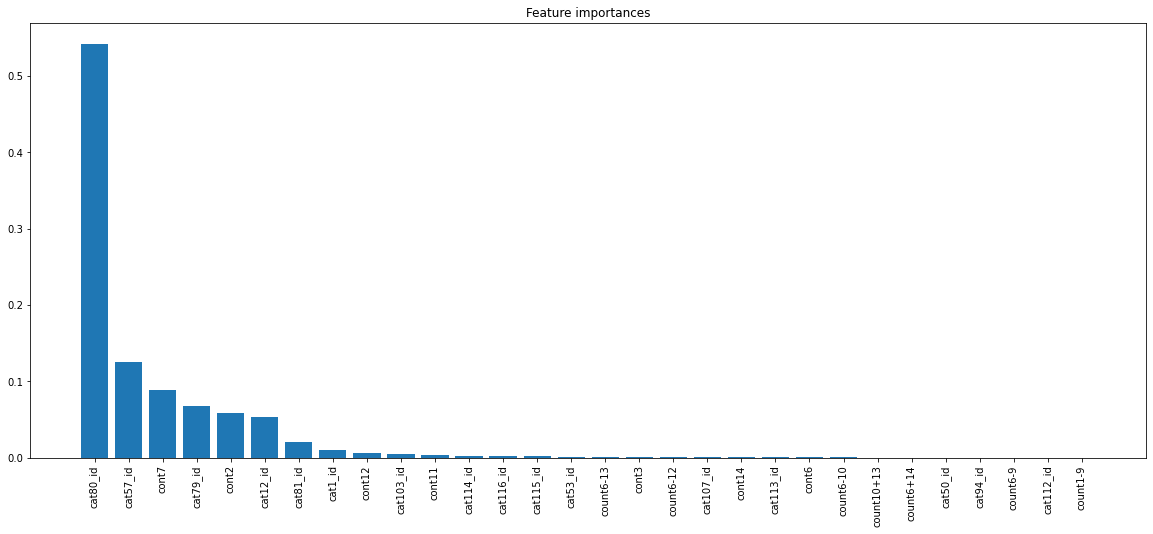

In [26]:
feats = cat_id_feats + num_feats + sum_feats + minus_feats
X = train[feats].values

model = RandomForestRegressor(max_depth=5, n_estimators=20)
model.fit(X, y)

h.plot_feature_importances(model, feats, limit=30)

W obu przypadkach na pierwszym miejscu jest **cat80**. Widać, że nowo utworzone cechy (dodawanie lub odejmowanie) również pojawiły się wśród 30 cech o najwyższym feature importance (np. **count10+13**).

Sprawdźmy teraz wykresy dla kilku zmiennych kategorialnych (`cat80`, `cat57` i `cat79`) i to, jaki mają one wpływ na `loss`. Pamiętaj, że `loss` jest skrzywiony, więc od razu porównamy również z `log_loss`.

In [27]:
def plot_cat_var_and_loss(cat_id):
    print( train[cat_id].value_counts() )
    print( train[cat_id].value_counts(normalize=True) )

    train[cat_id].hist()
    plt.show()

    print("Loss")
    plt.figure(figsize=(20, 8))
    for i in range(4):
        plt.subplot(221 + i)
        plt.boxplot( train[ train[cat_id] == i ]['loss'] )
        plt.title(cat_id + ' == {0}'.format(i))

    plt.show();

    print("Log Loss")
    plt.figure(figsize=(20, 8))
    for i in range(4):
        plt.subplot(221 + i)
        plt.boxplot( train[ train[cat_id] == i ]['log_loss'] )
        plt.title(cat_id + ' == {0}'.format(i))
        plt.ylim(0, 12)

    plt.show();

## Cat80

0    137505
1     46538
3      3492
2       783
Name: cat80_id, dtype: int64
0    0.730174
1    0.247125
3    0.018543
2    0.004158
Name: cat80_id, dtype: float64


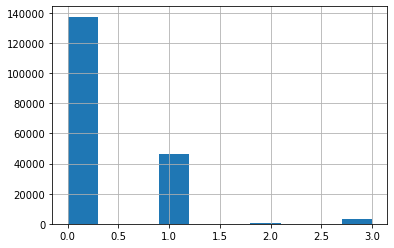

Loss


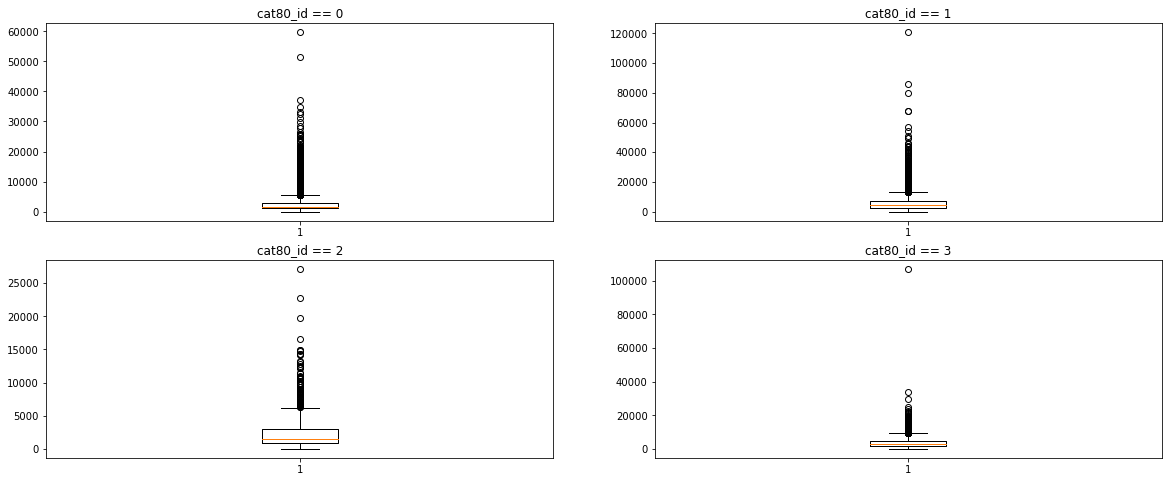

Log Loss


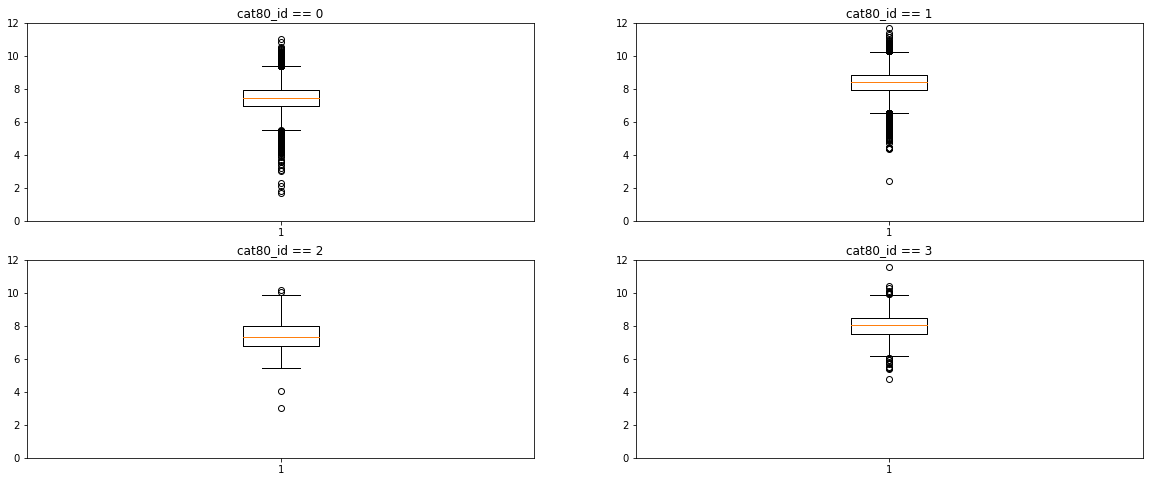

In [28]:
plot_cat_var_and_loss('cat80_id')

## Cat 57

0    185296
1      3022
Name: cat57_id, dtype: int64
0    0.983953
1    0.016047
Name: cat57_id, dtype: float64


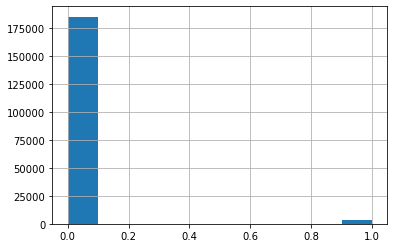

Loss


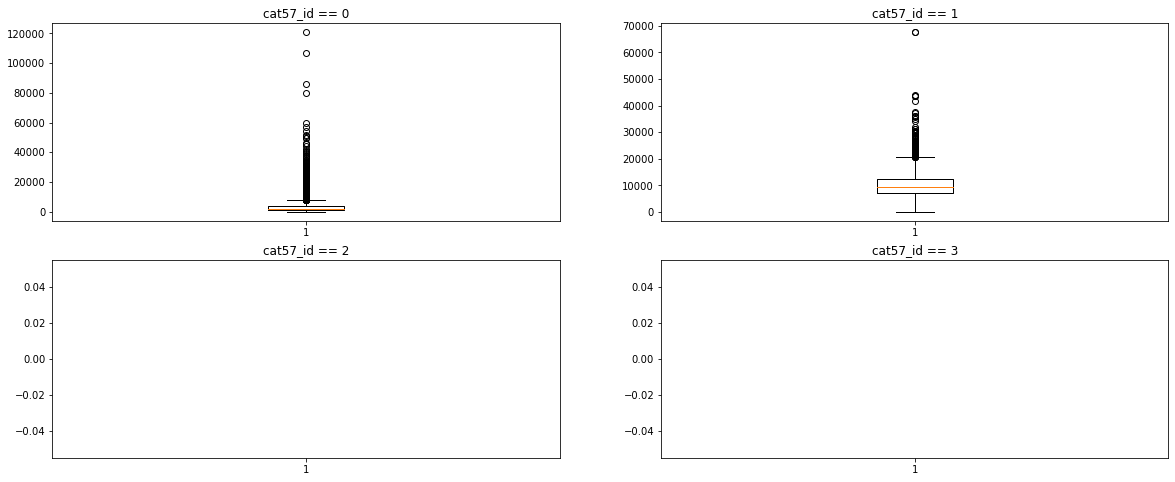

Log Loss


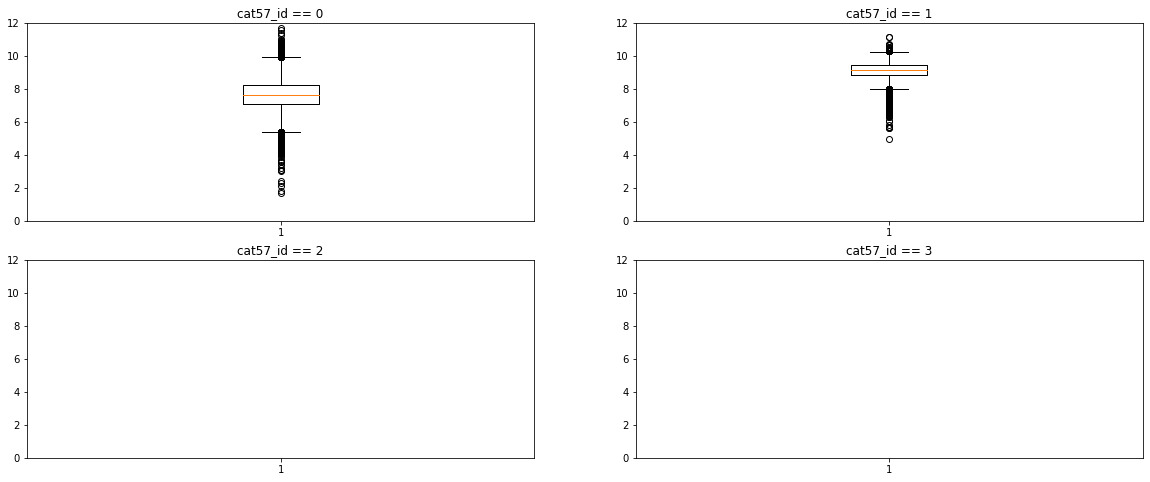

In [29]:
plot_cat_var_and_loss('cat57_id')

0    152929
1     26657
2      7064
3      1668
Name: cat79_id, dtype: int64
0    0.812079
1    0.141553
2    0.037511
3    0.008857
Name: cat79_id, dtype: float64


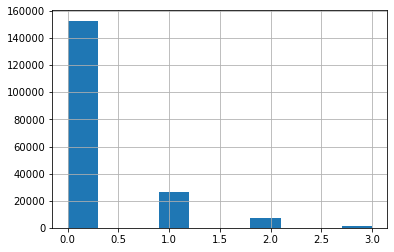

Loss


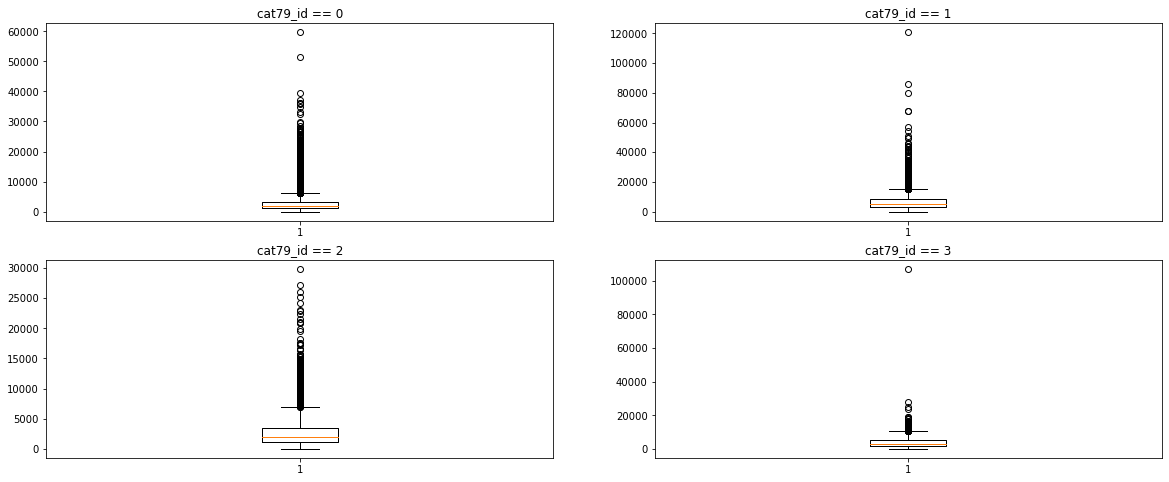

Log Loss


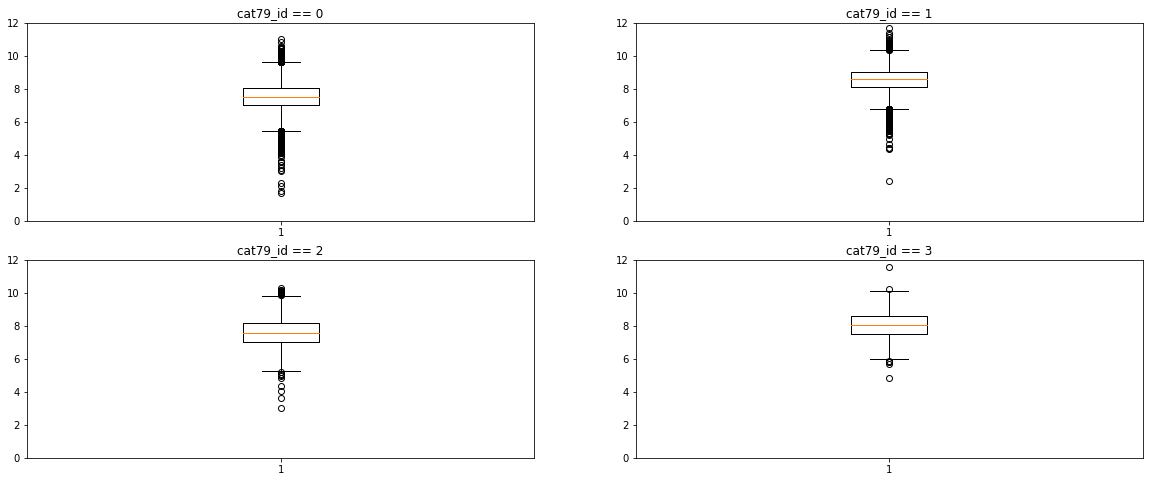

In [30]:
plot_cat_var_and_loss('cat79_id')

Widać, że jak używamy oryginalny **loss**, to wtedy jest dużo wartości odstających, natomiast po transformacji logarytmicznej wygląda to sensowniej. Dlatego zaczniemy stosować `log(loss)`.

## Log loss

Zbudujemy teraz model na `log(loss)`. Zbadajmy również przesunięcie `log(loss + shift)`, dobierając inny parameter `shift`.

In [31]:
X = train[ cat_id_feats + num_feats + sum_feats + minus_feats  ].values

run_log_cv(X, y, DecisionTreeRegressor(max_depth=5))

(1390.2324895797126, 11.928682612042532)

Jest poprawa: ~**1391** vs ~**1455**. Dobrze, będziemy dalej stosować `log(loss)`.

## XGBoost

Przejdźmy teraz na najwyższe obroty i użyjmy do tego `xgboost`. Zróbmy serię eksperymentów sprawdzając, jak zmienia się jakość w zależności od zbioru cech.

In [32]:
X = train[ cat_id_feats + num_feats + sum_feats + minus_feats  ].values
run_cv(X, y, xgb.XGBRegressor(objective='reg:squarederror'))

(1209.2480124790336, 3.532440150794507)

**XGBoost** już na starcie nieźle sobie poradził: ~**1209** vs ~**1387**.

Warto spróbować osiągnąć jeszcze więcej :)

## Advanced XGBoost
Na początek zdefiniujmy kilka funkcji, żeby się nie powtarzać.

In [33]:
shift = 1
def eval_mae(y_pred_log, dtrain):
    y      = np.exp(dtrain.get_label()) - shift
    y_pred = np.exp(y_pred_log) - shift
    
    return 'mae', mean_absolute_error(y,y_pred)

In [34]:
def plot_xgb_learning_curve(train_evals, test_evals):
    mean_train_evals = np.mean(train_evals, axis=0)
    std_train_evals = np.std(train_evals, axis=0)

    mean_test_evals = np.mean(test_evals, axis=0)
    std_test_evals = np.std(test_evals, axis=0)

    plt.figure(figsize=(15, 5))

    plt.fill_between(range(len(mean_train_evals)), mean_train_evals - std_train_evals*3,
                     mean_train_evals + std_train_evals*3, alpha=0.1,
                     color="r")

    plt.fill_between(range(len(mean_test_evals)), mean_test_evals - std_test_evals*3,
                     mean_test_evals + std_test_evals*3, alpha=0.1,
                     color="g")


    plt.plot(mean_train_evals, label='train', c='r')
    plt.plot(mean_test_evals, label='test', c='g')
    plt.legend(loc='best')
    plt.title("Learning curve")
    plt.xlabel("# iterations")
    plt.ylabel("mae")
    plt.show()
    
    
def cv_xgb(df, feats, xgb_params, shift=1, folds=3, verbose=False, early_stopping_rounds=5, plot_lc=True, return_model=False):
    X = df[ feats ].values
    y = df['loss'].values
    y_log = np.log( y + shift )
    
    cv = KFold(n_splits=3, shuffle=True, random_state=2019)

    scores = []
    train_evals, test_evals = [], []
    for train_idx, test_idx in tqdm( cv.split(X) ):

        model = xgb.XGBRegressor(**xgb_params)
        eval_set = [ (X[train_idx], y_log[train_idx]), (X[test_idx], y_log[test_idx]),  ]
        model.fit(X[train_idx], y_log[train_idx], eval_metric=eval_mae, eval_set=eval_set, verbose=verbose, early_stopping_rounds=early_stopping_rounds)
        y_pred_log = model.predict(X[test_idx])
        y_pred_log[ y_pred_log < 0 ] = 1e-6
        y_pred = np.exp( y_pred_log ) - shift

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
        
        evals_result = model.evals_result()

        if plot_lc:
            train_evals.append( evals_result['validation_0']['mae'] )
            test_evals.append( evals_result['validation_1']['mae'] )

    if plot_lc:
        def norm_rows(rows):
            min_rows = min( [len(x) for x in rows])
            return [x[:min_rows] for x in rows]

        plot_xgb_learning_curve(norm_rows(train_evals), norm_rows(test_evals))
        
    if return_model:
        return model, np.mean(scores), np.std(scores)
    
    return np.mean(scores), np.std(scores)

3it [00:47, 15.86s/it]


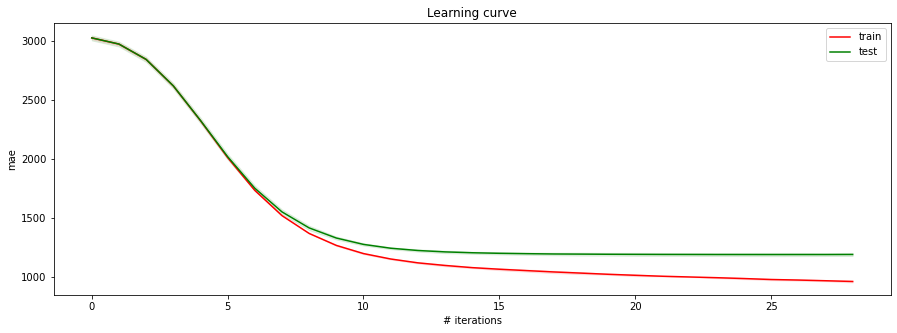

(1187.8556290295355, 4.401917348313897)

In [35]:
feats = num_feats + cat_id_feats + sum_feats + minus_feats

xgb_params = {
    'n_estimators': 50,
    'max_depth': 10,
    'learning_rate': 0.3,
    'random_state': 2019,
    'objective': 'reg:squarederror'
}
cv_xgb(train, feats, xgb_params, shift=shift)

Kolejna poprawa: ~**1187** vs ~**1209**.

Pamiętasz, że nasze zmienne ciągle dość często miały rozkład skośny? Spróbujmy to naprawić wykorzystując transformację: `minmax_scale` + `sqrt` lub `log`.

## Normalize `numerical` variables

In [36]:
all_cont_feats = [feat for feat in train.columns if feat.startswith('cont')]
[ (feat, train[feat].skew()) for feat in all_cont_feats ]

[('cont1', 0.5164240212162501),
 ('cont2', -0.31094125136830164),
 ('cont3', -0.010002283912087023),
 ('cont4', 0.4160960294956771),
 ('cont5', 0.6816224364137882),
 ('cont6', 0.4612142679626868),
 ('cont7', 0.8260528331279865),
 ('cont8', 0.6766340713246526),
 ('cont9', 1.072428719811583),
 ('cont10', 0.35500094742512944),
 ('cont11', 0.28082142843754276),
 ('cont12', 0.2919920804036288),
 ('cont13', 0.3807422004805747),
 ('cont14', 0.24867408719289721)]

In [37]:
for feat in tqdm(all_cont_feats):
    if train[feat].skew() < 0.25: continue
    train[feat + '_sqrt'] = np.sqrt( minmax_scale(train[feat]) )
    train[feat + '_log1p'] = np.log1p( minmax_scale(train[feat]) )
    
sqrt_cont_feats = [feat for feat in train.columns if feat.startswith('cont') and 'sqrt' in feat]
log_cont_feats = [feat for feat in train.columns if feat.startswith('cont') and 'log' in feat]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 104.81it/s]


Sprawdźmy, czy to pomogło.

3it [00:42, 14.15s/it]


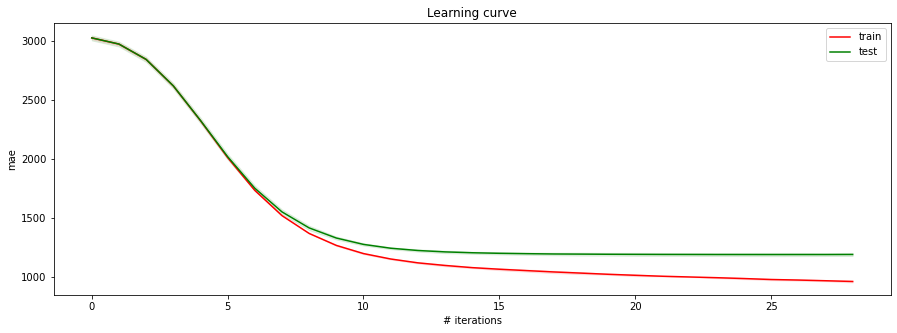

(1187.8556290295355, 4.401917348313897)

In [38]:
feats = num_feats + cat_id_feats + sum_feats + minus_feats + sqrt_cont_feats + log_cont_feats

xgb_params = {
    'n_estimators': 50,
    'max_depth': 10,
    'learning_rate': 0.3,
    'random_state': 0,
    'objective': 'reg:squarederror',
}
cv_xgb(train, feats, xgb_params, shift=1)

Niewiele lepiej, ale to może jeszcze być pomocne, jak zaczniemy optymalizować *hyper-parameters*. Można jeszcze spróbować innych kombinacji z cechami... Jak masz chwilę czasu, to jak najbardziej możesz spróbować. 

### Przesunięcie `log(loss + shift)`
Zwrócę jeszcze Twoją uwagę na przesunięcia `log(loss + shift)`.

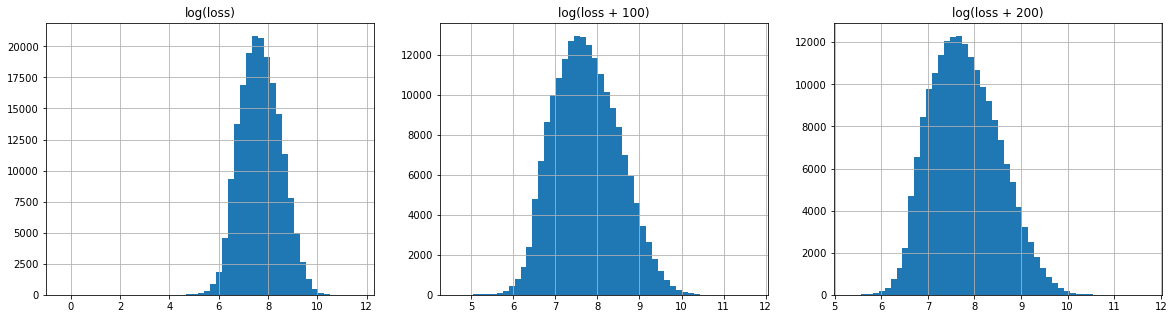

In [39]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
np.log( train['loss'] ).hist(bins=50)
plt.title('log(loss)')

plt.subplot(132)
np.log( train['loss'] + 100).hist(bins=50)
plt.title('log(loss + 100)')

plt.subplot(133)
np.log( train['loss'] + 200).hist(bins=50)
plt.title('log(loss + 200)');

3it [00:41, 13.84s/it]


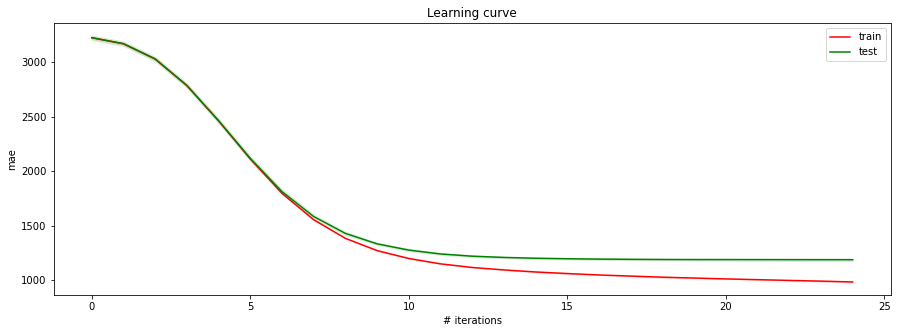

(1188.1087007136302, 3.94286567512281)

In [40]:
cv_xgb(train, feats, xgb_params, shift=200)

Cały czas podobnie, ale przykładając się do optymalizacji, da się wyciągnąć więcej.

## Hyperopt
UWAGA! Poniższe komórki mogą liczyć się nawet kilkadziesiąt minut.

{'max_depth': 17, 'colsample_bytree': 0.8963110067015856, 'learning_rate': 0.13026575797557993, 'subsample': 0.8351598876588381, 'seed': 2019, 'min_child_weight': 70, 'reg_alpha': 2.3490226293372385, 'reg_lambda': 0.7560395123023093, 'n_estimators': 100, 'objective': 'reg:squarederror'}
  0%|                                                                                            | 0/30 [00:00<?, ?trial/s, best loss=?]

0it [00:00, ?it/s]

1it [00:43, 43.39s/it]

2it [01:29, 44.74s/it]

3it [02:12, 44.04s/it]

3it [02:12, 44.10s/it]


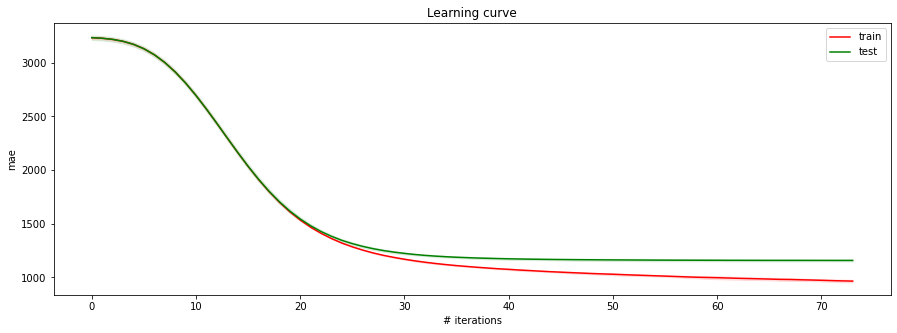

score:                                                                                                                                  
1158.777834497659                                                                                                                       
3.379715873847241                                                                                                                       
{'max_depth': 19, 'colsample_bytree': 0.9922191794419807, 'learning_rate': 0.1363688813252286, 'subsample': 0.8562863096362905, 'seed': 2019, 'min_child_weight': 60, 'reg_alpha': 2.6325764034612438, 'reg_lambda': 0.7245555267860585, 'n_estimators': 100, 'objective': 'reg:squarederror'}
  3%|██▏                                                             | 1/30 [02:12<1:04:06, 132.63s/trial, best loss: 1158.777834497659]

0it [00:00, ?it/s]

1it [00:46, 46.64s/it]

2it [01:48, 55.69s/it]

3it [02:45, 56.15s/it]

3it [02:45, 55.12s/it]


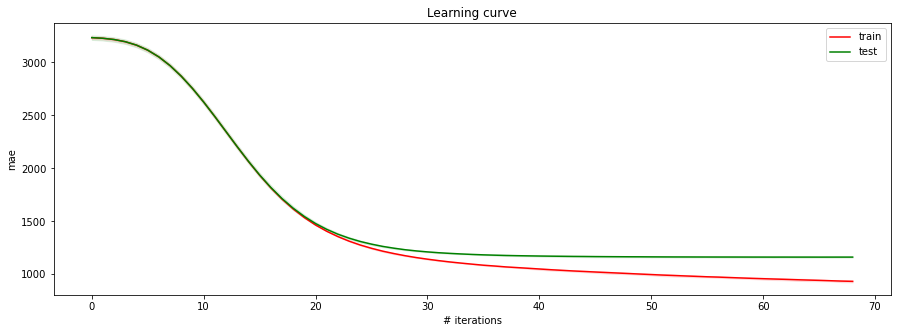

score:                                                                                                                                  
1161.9715103884894                                                                                                                      
1.7204754827406372                                                                                                                      
{'max_depth': 8, 'colsample_bytree': 0.41285974141817383, 'learning_rate': 0.05919879197106702, 'subsample': 0.602082714060685, 'seed': 2019, 'min_child_weight': 200, 'reg_alpha': 1.2773153365019336, 'reg_lambda': 0.950673726208892, 'n_estimators': 100, 'objective': 'reg:squarederror'}
  7%|████▎                                                           | 2/30 [04:58<1:10:58, 152.11s/trial, best loss: 1158.777834497659]

0it [00:00, ?it/s]

1it [00:18, 18.40s/it]

2it [00:36, 18.42s/it]

3it [00:56, 18.86s/it]

3it [00:56, 18.74s/it]


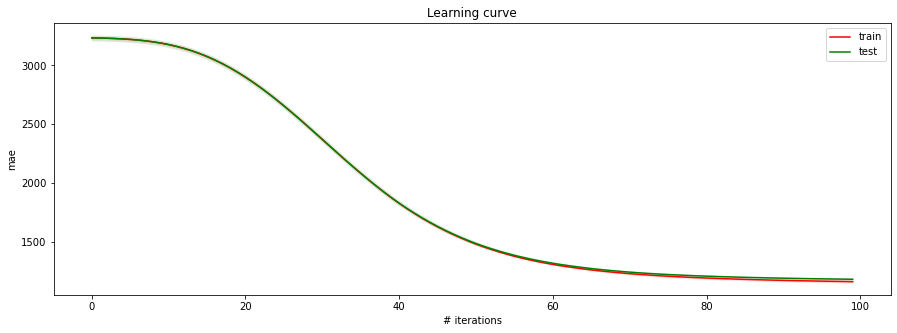

score:                                                                                                                                  
1181.7323677441357                                                                                                                      
2.2310312878402336                                                                                                                      
{'max_depth': 19, 'colsample_bytree': 0.9167003782368094, 'learning_rate': 0.18930558793003605, 'subsample': 0.9861955821679974, 'seed': 2019, 'min_child_weight': 10, 'reg_alpha': 2.5397668191617417, 'reg_lambda': 0.709734531159371, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 10%|██████▌                                                           | 3/30 [05:54<48:49, 108.50s/trial, best loss: 1158.777834497659]

0it [00:00, ?it/s]

1it [00:35, 35.36s/it]

2it [01:12, 36.59s/it]

3it [01:43, 33.90s/it]

3it [01:43, 34.50s/it]


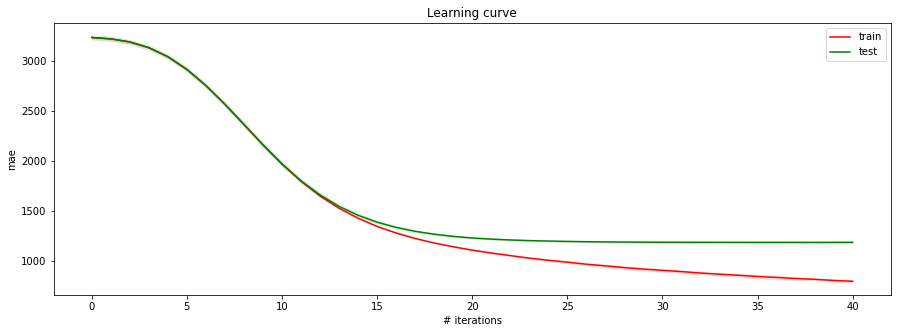

score:                                                                                                                                  
1182.7747948623091                                                                                                                      
3.107346471011656                                                                                                                       
{'max_depth': 13, 'colsample_bytree': 0.711712091586256, 'learning_rate': 0.06255189522815019, 'subsample': 0.6582224901901039, 'seed': 2019, 'min_child_weight': 150, 'reg_alpha': 1.8290683467420905, 'reg_lambda': 0.836315652040282, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 13%|████████▊                                                         | 4/30 [07:38<46:13, 106.66s/trial, best loss: 1158.777834497659]

0it [00:00, ?it/s]

1it [00:34, 34.97s/it]

2it [01:09, 34.98s/it]

3it [01:44, 34.89s/it]

3it [01:44, 34.91s/it]


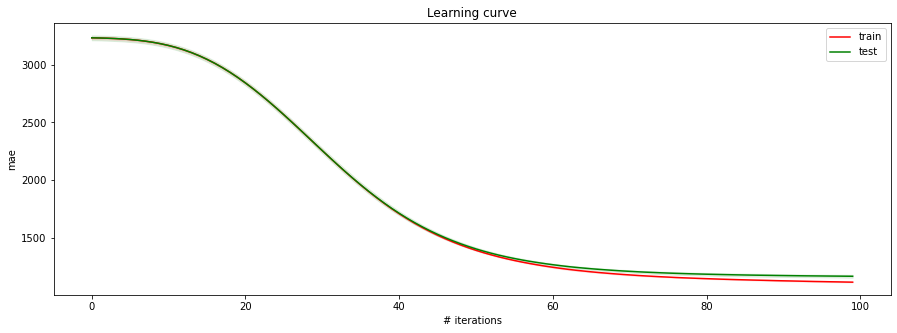

score:                                                                                                                                  
1164.7030020368                                                                                                                         
4.30696006840943                                                                                                                        
{'max_depth': 14, 'colsample_bytree': 0.20402693460997035, 'learning_rate': 0.1265641863423338, 'subsample': 0.7872982377298975, 'seed': 2019, 'min_child_weight': 90, 'reg_alpha': 1.832862323331802, 'reg_lambda': 0.8562208705729187, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 17%|███████████                                                       | 5/30 [09:23<44:12, 106.09s/trial, best loss: 1158.777834497659]

0it [00:00, ?it/s]

1it [00:17, 17.92s/it]

2it [00:36, 18.12s/it]

3it [00:54, 18.32s/it]

3it [00:54, 18.24s/it]


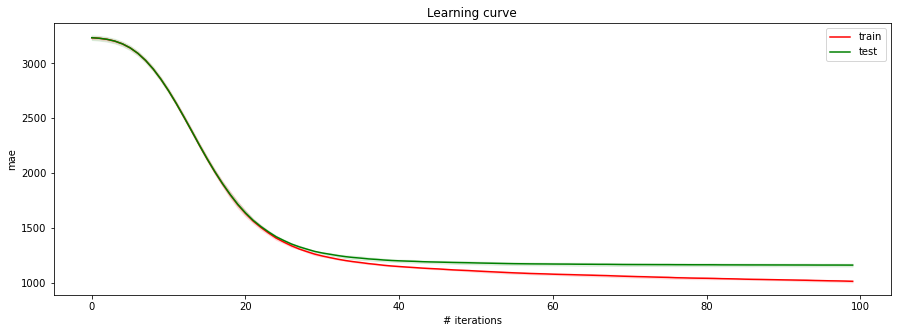

score:                                                                                                                                  
1163.436084696605                                                                                                                       
4.444873323244046                                                                                                                       
{'max_depth': 5, 'colsample_bytree': 0.7406943312875571, 'learning_rate': 0.19644729330871857, 'subsample': 0.9927258516252899, 'seed': 2019, 'min_child_weight': 10, 'reg_alpha': 1.1326891386144782, 'reg_lambda': 0.8117175904902844, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 20%|█████████████▍                                                     | 6/30 [10:18<35:29, 88.74s/trial, best loss: 1158.777834497659]

0it [00:00, ?it/s]

1it [00:17, 17.03s/it]

2it [00:33, 16.96s/it]

3it [00:50, 16.90s/it]

3it [00:50, 16.93s/it]


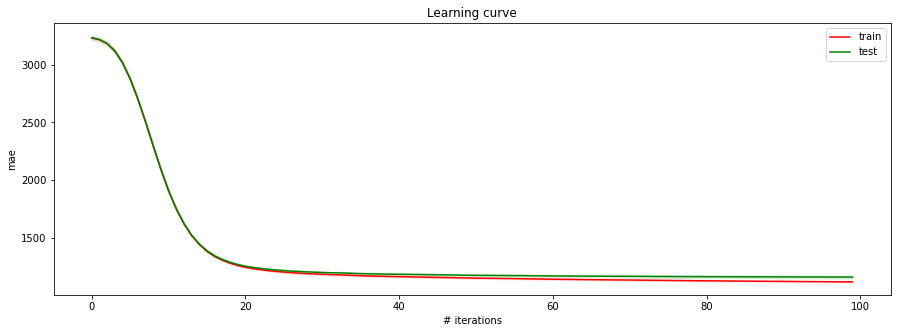

score:                                                                                                                                  
1163.6675449258726                                                                                                                      
4.6639937415949495                                                                                                                      
{'max_depth': 17, 'colsample_bytree': 0.4471231889718297, 'learning_rate': 0.09380102846975064, 'subsample': 0.8368161592201854, 'seed': 2019, 'min_child_weight': 150, 'reg_alpha': 2.222015580647828, 'reg_lambda': 0.9667386461333021, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 23%|███████████████▋                                                   | 7/30 [11:10<29:18, 76.44s/trial, best loss: 1158.777834497659]

0it [00:00, ?it/s]

1it [00:31, 31.66s/it]

2it [01:03, 31.90s/it]

3it [01:35, 31.98s/it]

3it [01:35, 31.94s/it]


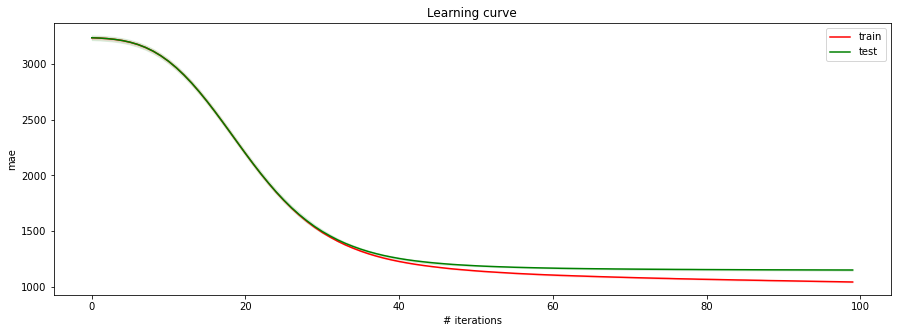

score:                                                                                                                                  
1153.024580642414                                                                                                                       
2.199607010932363                                                                                                                       
{'max_depth': 11, 'colsample_bytree': 0.4192299927700335, 'learning_rate': 0.09426347723984556, 'subsample': 0.7111677997143071, 'seed': 2019, 'min_child_weight': 200, 'reg_alpha': 1.4009560877354856, 'reg_lambda': 0.9930565225251649, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 27%|█████████████████▊                                                 | 8/30 [12:46<30:19, 82.71s/trial, best loss: 1153.024580642414]

0it [00:00, ?it/s]

1it [00:21, 21.76s/it]

2it [00:43, 21.63s/it]

3it [01:04, 21.53s/it]

3it [01:04, 21.57s/it]


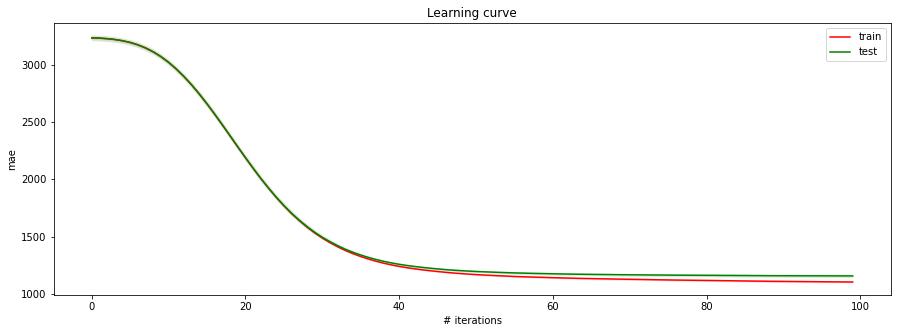

score:                                                                                                                                  
1157.039831561295                                                                                                                       
3.354522102925389                                                                                                                       
{'max_depth': 16, 'colsample_bytree': 0.21474696083000192, 'learning_rate': 0.16239218366340497, 'subsample': 0.9009529035763936, 'seed': 2019, 'min_child_weight': 140, 'reg_alpha': 2.1096906508553706, 'reg_lambda': 0.941682240176826, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 30%|████████████████████                                               | 9/30 [13:51<27:00, 77.19s/trial, best loss: 1153.024580642414]

0it [00:00, ?it/s]

1it [00:18, 18.81s/it]

2it [00:37, 18.72s/it]

3it [00:54, 17.91s/it]

3it [00:54, 18.14s/it]


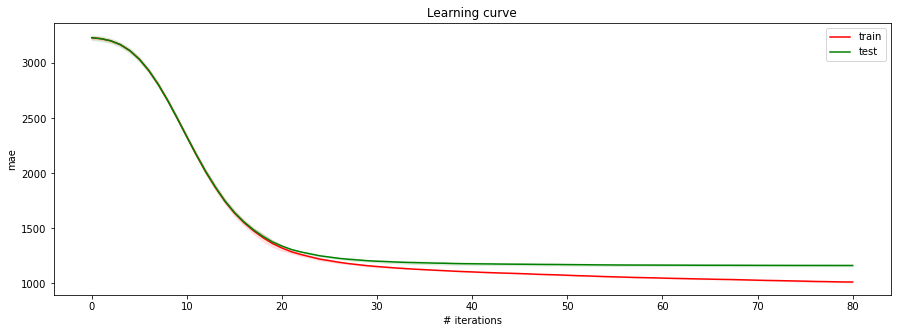

score:                                                                                                                                  
1162.6478215316904                                                                                                                      
2.7195202573782096                                                                                                                      
{'max_depth': 10, 'colsample_bytree': 0.4452405397945493, 'learning_rate': 0.08687228030075383, 'subsample': 0.7445227135044543, 'seed': 2019, 'min_child_weight': 150, 'reg_alpha': 1.4634540386584822, 'reg_lambda': 0.9023770813188661, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 33%|██████████████████████                                            | 10/30 [14:46<23:25, 70.27s/trial, best loss: 1153.024580642414]

0it [00:00, ?it/s]

1it [00:21, 21.11s/it]

2it [00:42, 21.26s/it]

3it [01:03, 21.33s/it]

3it [01:03, 21.30s/it]


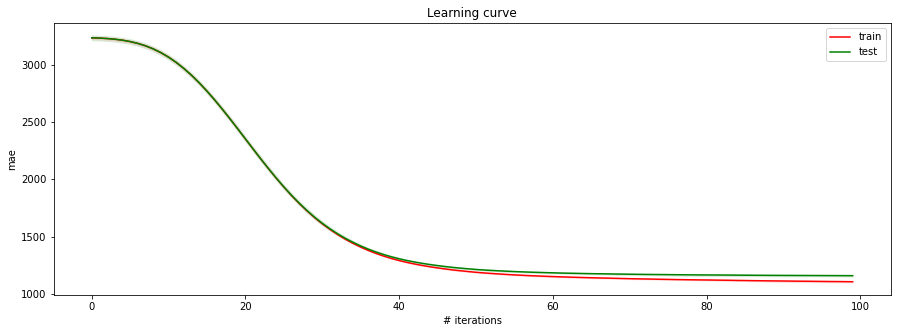

score:                                                                                                                                  
1158.3270849122894                                                                                                                      
2.791150726605795                                                                                                                       
{'max_depth': 16, 'colsample_bytree': 0.5698926267170993, 'learning_rate': 0.09381880383807083, 'subsample': 0.9242412145080963, 'seed': 2019, 'min_child_weight': 180, 'reg_alpha': 1.0357884319900101, 'reg_lambda': 0.9967490968577811, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 37%|████████████████████████▏                                         | 11/30 [15:50<21:40, 68.43s/trial, best loss: 1153.024580642414]

0it [00:00, ?it/s]

1it [00:38, 38.65s/it]

2it [01:17, 38.63s/it]

3it [01:57, 39.42s/it]

3it [01:57, 39.21s/it]


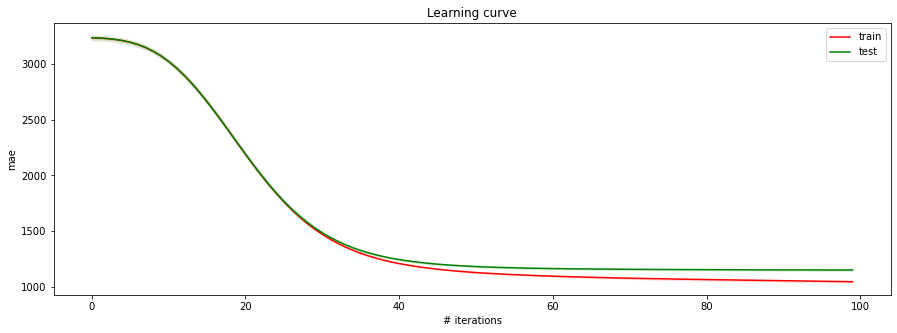

score:                                                                                                                                  
1151.785072761544                                                                                                                       
2.880439376869926                                                                                                                       
{'max_depth': 6, 'colsample_bytree': 0.6468983290716659, 'learning_rate': 0.16804796348507672, 'subsample': 0.9326706325883308, 'seed': 2019, 'min_child_weight': 180, 'reg_alpha': 1.0343804687802485, 'reg_lambda': 0.8971158809688224, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 40%|██████████████████████████▍                                       | 12/30 [17:48<25:03, 83.51s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:18, 18.82s/it]

2it [00:38, 19.21s/it]

3it [00:58, 19.50s/it]

3it [00:58, 19.38s/it]


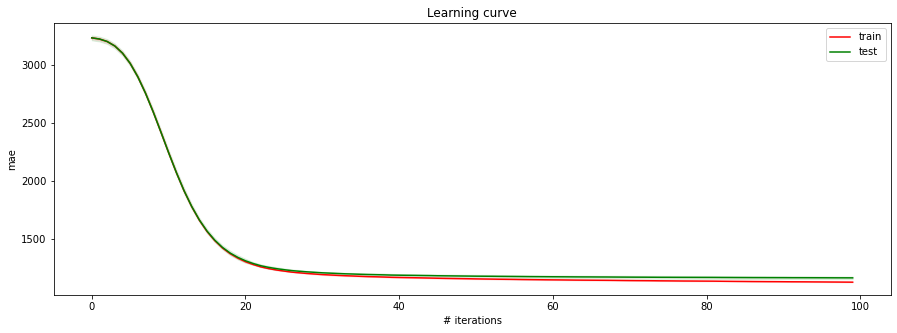

score:                                                                                                                                  
1160.6770638712762                                                                                                                      
3.8347667564241217                                                                                                                      
{'max_depth': 15, 'colsample_bytree': 0.3179805077547254, 'learning_rate': 0.10716494322684053, 'subsample': 0.9370344767243474, 'seed': 2019, 'min_child_weight': 120, 'reg_alpha': 1.1205621240296366, 'reg_lambda': 0.7927059685901277, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 43%|████████████████████████████▌                                     | 13/30 [18:46<21:30, 75.94s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:25, 25.93s/it]

2it [00:51, 25.80s/it]

3it [01:17, 25.84s/it]

3it [01:17, 25.84s/it]


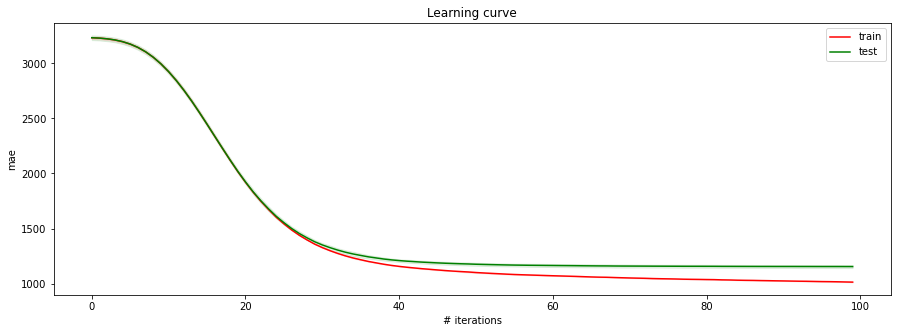

score:                                                                                                                                  
1154.276083653907                                                                                                                       
4.698931336249695                                                                                                                       
{'max_depth': 20, 'colsample_bytree': 0.5562671606275866, 'learning_rate': 0.155267318283325, 'subsample': 0.6509917722757317, 'seed': 2019, 'min_child_weight': 40, 'reg_alpha': 1.0163496304901534, 'reg_lambda': 0.9007377692780297, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 47%|██████████████████████████████▊                                   | 14/30 [20:04<20:24, 76.55s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:23, 23.57s/it]

2it [00:46, 23.22s/it]

3it [01:13, 24.76s/it]

3it [01:13, 24.38s/it]


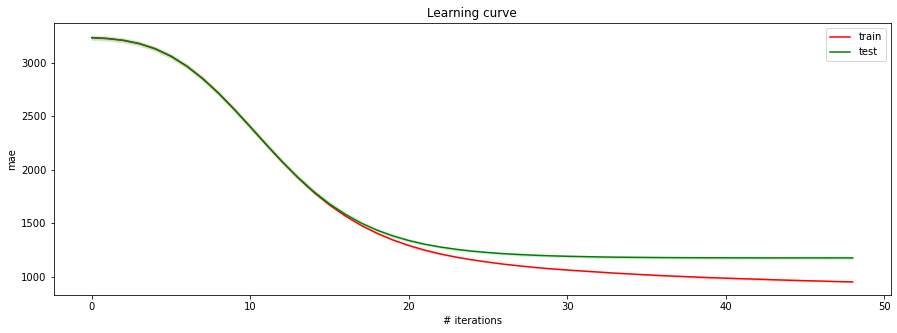

score:                                                                                                                                  
1174.3629287452056                                                                                                                      
3.225133764240221                                                                                                                       
{'max_depth': 11, 'colsample_bytree': 0.8138200204525433, 'learning_rate': 0.0723539921040666, 'subsample': 0.7789246237654788, 'seed': 2019, 'min_child_weight': 180, 'reg_alpha': 1.6070709046422575, 'reg_lambda': 0.989610209960127, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 50%|█████████████████████████████████                                 | 15/30 [21:18<18:54, 75.63s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:36, 36.38s/it]

2it [01:13, 36.76s/it]

3it [01:50, 36.88s/it]

3it [01:50, 36.81s/it]


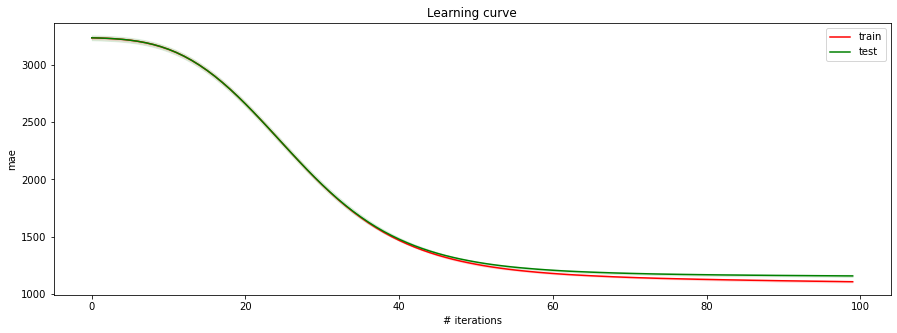

score:                                                                                                                                  
1159.6664544673797                                                                                                                      
2.9942071501817558                                                                                                                      
{'max_depth': 8, 'colsample_bytree': 0.5582405102055126, 'learning_rate': 0.11266404376425014, 'subsample': 0.8992497014209225, 'seed': 2019, 'min_child_weight': 110, 'reg_alpha': 1.2462094608714192, 'reg_lambda': 0.8634316428719923, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 53%|███████████████████████████████████▏                              | 16/30 [23:09<20:07, 86.22s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:22, 22.30s/it]

2it [00:44, 22.42s/it]

3it [01:07, 22.73s/it]

3it [01:07, 22.63s/it]


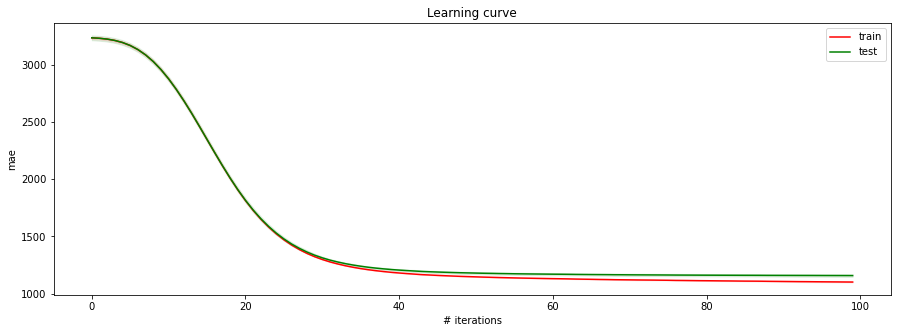

score:                                                                                                                                  
1157.3534342487565                                                                                                                      
3.6383793199805767                                                                                                                      
{'max_depth': 17, 'colsample_bytree': 0.5029407880028293, 'learning_rate': 0.08280218940164016, 'subsample': 0.8271259384853288, 'seed': 2019, 'min_child_weight': 170, 'reg_alpha': 2.1291630858542026, 'reg_lambda': 0.9588404027457205, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 57%|█████████████████████████████████████▍                            | 17/30 [24:17<17:30, 80.82s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:35, 35.99s/it]

2it [01:11, 35.80s/it]

3it [01:48, 36.50s/it]

3it [01:48, 36.33s/it]


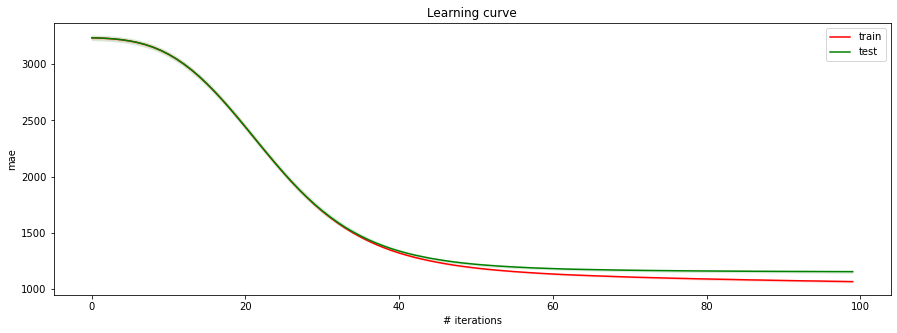

score:                                                                                                                                  
1154.2791434335295                                                                                                                      
3.4376265363007983                                                                                                                      
{'max_depth': 18, 'colsample_bytree': 0.32480694043610714, 'learning_rate': 0.10566227818938861, 'subsample': 0.8735062427290541, 'seed': 2019, 'min_child_weight': 130, 'reg_alpha': 1.8307842980374216, 'reg_lambda': 0.9981907046907077, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 60%|███████████████████████████████████████▌                          | 18/30 [26:06<17:52, 89.39s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:29, 29.17s/it]

2it [00:57, 28.82s/it]

3it [01:26, 28.99s/it]

3it [01:26, 28.98s/it]


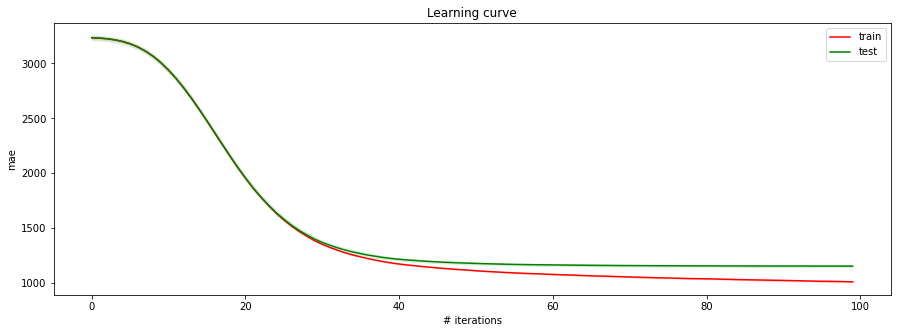

score:                                                                                                                                  
1154.54484194947                                                                                                                        
2.8992571754203054                                                                                                                      
{'max_depth': 15, 'colsample_bytree': 0.6113731837861214, 'learning_rate': 0.07713668473579303, 'subsample': 0.9571895832734945, 'seed': 2019, 'min_child_weight': 160, 'reg_alpha': 2.1115187204692343, 'reg_lambda': 0.968592632782934, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 63%|█████████████████████████████████████████▊                        | 19/30 [27:34<16:16, 88.76s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:45, 45.68s/it]

2it [01:33, 46.69s/it]

3it [02:21, 47.56s/it]

3it [02:21, 47.23s/it]


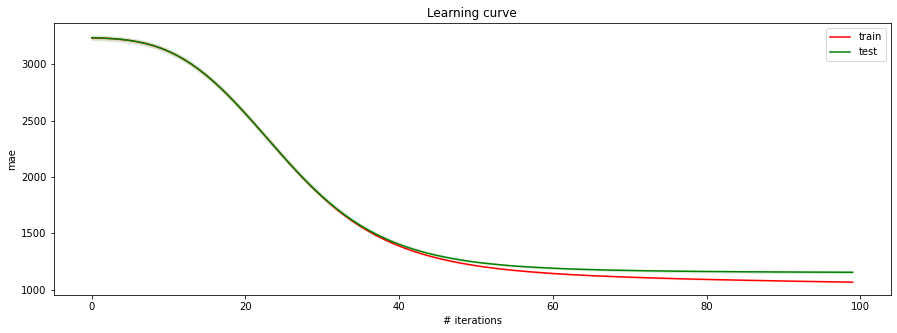

score:                                                                                                                                  
1153.9686205099663                                                                                                                      
3.1149040804505073                                                                                                                      
{'max_depth': 13, 'colsample_bytree': 0.3167223783099949, 'learning_rate': 0.05360590417152074, 'subsample': 0.8950804091550586, 'seed': 2019, 'min_child_weight': 190, 'reg_alpha': 2.368659632982888, 'reg_lambda': 0.9235677680606624, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 67%|███████████████████████████████████████████▎                     | 20/30 [29:56<17:27, 104.78s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:23, 23.48s/it]

2it [00:47, 23.53s/it]

3it [01:09, 23.23s/it]

3it [01:09, 23.31s/it]


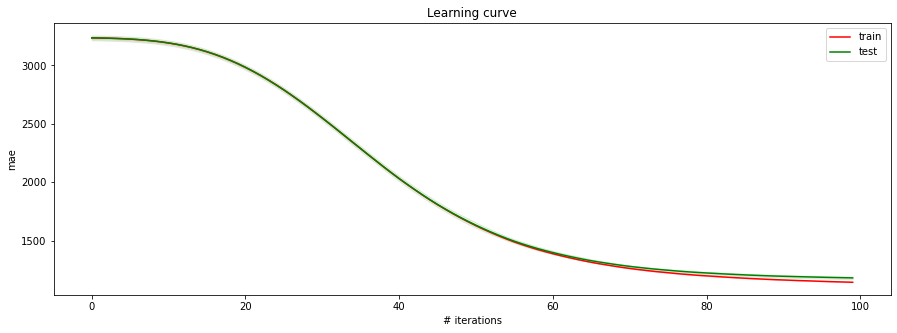

score:                                                                                                                                  
1181.5594468950942                                                                                                                      
4.0163190354217235                                                                                                                      
{'max_depth': 16, 'colsample_bytree': 0.4929707675312059, 'learning_rate': 0.09723859288678541, 'subsample': 0.810337364966443, 'seed': 2019, 'min_child_weight': 90, 'reg_alpha': 1.6319142421980022, 'reg_lambda': 0.9995163276110385, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 70%|██████████████████████████████████████████████▏                   | 21/30 [31:06<14:10, 94.45s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:38, 38.10s/it]

2it [01:19, 40.08s/it]

3it [02:01, 40.92s/it]

3it [02:01, 40.50s/it]


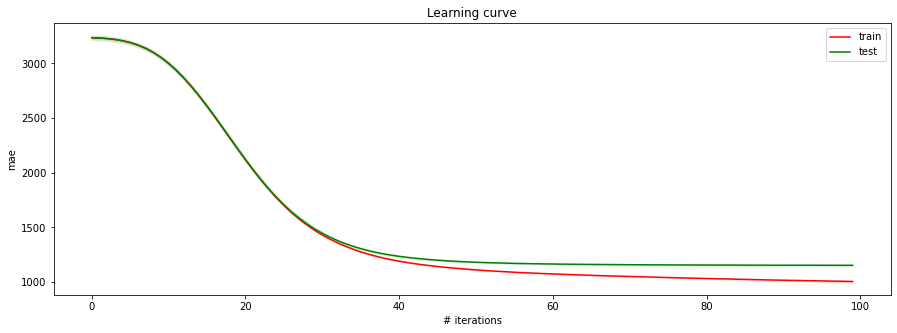

score:                                                                                                                                  
1154.2892358293739                                                                                                                      
2.2171278749625842                                                                                                                      
{'max_depth': 18, 'colsample_bytree': 0.37890450957187416, 'learning_rate': 0.11888848645578869, 'subsample': 0.7636233768074783, 'seed': 2019, 'min_child_weight': 160, 'reg_alpha': 1.9483308619605588, 'reg_lambda': 0.9744127552988275, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 73%|███████████████████████████████████████████████▋                 | 22/30 [33:08<13:41, 102.68s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:33, 33.08s/it]

2it [01:06, 33.28s/it]

3it [01:38, 32.48s/it]

3it [01:38, 32.67s/it]


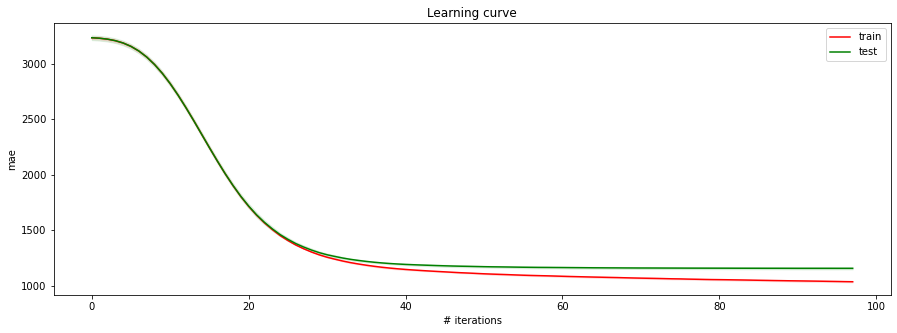

score:                                                                                                                                  
1155.097101757747                                                                                                                       
3.365868947084007                                                                                                                       
{'max_depth': 20, 'colsample_bytree': 0.6864255740522288, 'learning_rate': 0.07022295468967034, 'subsample': 0.9596627919822447, 'seed': 2019, 'min_child_weight': 130, 'reg_alpha': 1.51859724944704, 'reg_lambda': 0.9286444656076148, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 77%|█████████████████████████████████████████████████▊               | 23/30 [34:46<11:49, 101.40s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:55, 55.41s/it]

2it [01:52, 56.45s/it]

3it [02:49, 56.45s/it]

3it [02:49, 56.35s/it]


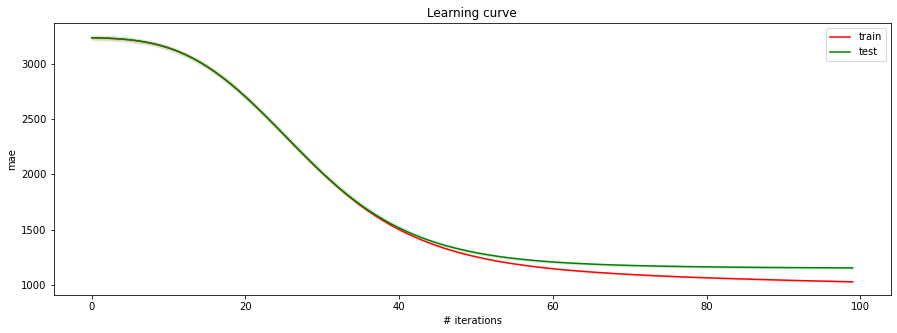

score:                                                                                                                                  
1153.5008950161887                                                                                                                      
2.937800533601497                                                                                                                       
{'max_depth': 15, 'colsample_bytree': 0.778928048390922, 'learning_rate': 0.1399078532501493, 'subsample': 0.7209497547249397, 'seed': 2019, 'min_child_weight': 170, 'reg_alpha': 2.7150699323906236, 'reg_lambda': 0.883983480743849, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 80%|████████████████████████████████████████████████████             | 24/30 [37:36<12:10, 121.81s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:42, 42.26s/it]

2it [01:23, 41.84s/it]

3it [01:57, 38.11s/it]

3it [01:57, 39.16s/it]


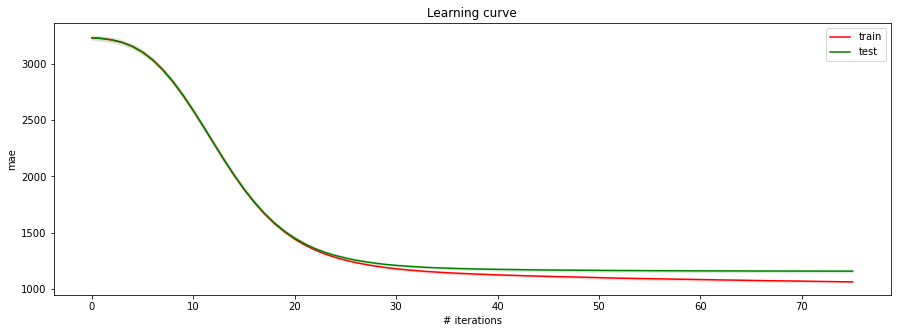

score:                                                                                                                                  
1155.947515059589                                                                                                                       
3.3871640663446447                                                                                                                      
{'max_depth': 17, 'colsample_bytree': 0.5065133108821502, 'learning_rate': 0.09595982215491577, 'subsample': 0.8600228557820805, 'seed': 2019, 'min_child_weight': 190, 'reg_alpha': 1.3321430124640499, 'reg_lambda': 0.9247983148547781, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 83%|██████████████████████████████████████████████████████▏          | 25/30 [39:34<10:03, 120.62s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:37, 37.52s/it]

2it [01:15, 37.74s/it]

3it [01:51, 37.06s/it]

3it [01:51, 37.23s/it]


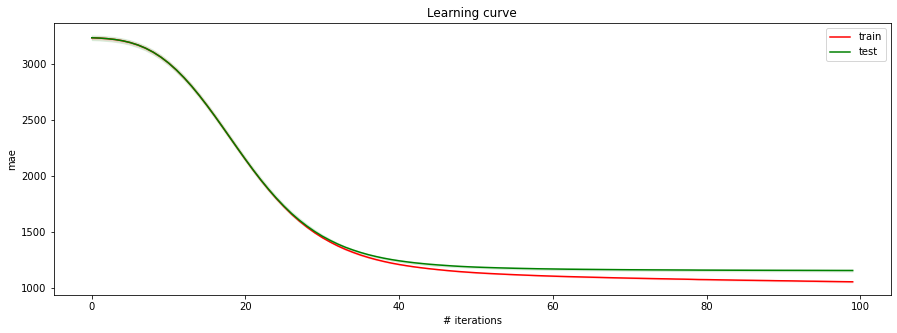

score:                                                                                                                                  
1152.2918627877577                                                                                                                      
3.222294505908402                                                                                                                       
{'max_depth': 14, 'colsample_bytree': 0.5583205151153414, 'learning_rate': 0.10019135493427504, 'subsample': 0.86908331299696, 'seed': 2019, 'min_child_weight': 200, 'reg_alpha': 1.2868036996525751, 'reg_lambda': 0.9212397905908734, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 87%|████████████████████████████████████████████████████████▎        | 26/30 [41:26<07:52, 118.05s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:34, 34.42s/it]

2it [01:09, 35.04s/it]

3it [01:45, 35.37s/it]

3it [01:45, 35.22s/it]


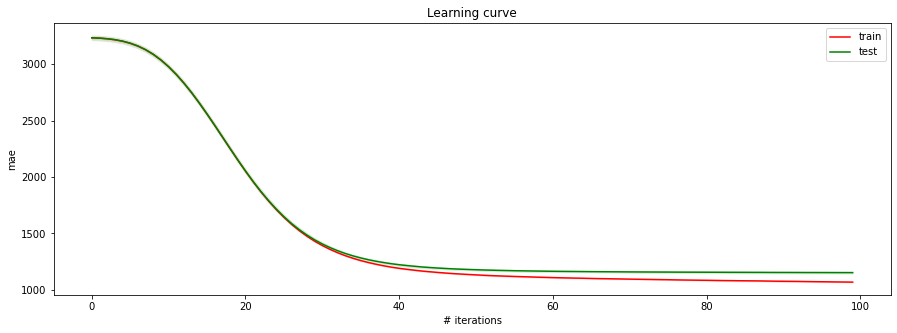

score:                                                                                                                                  
1152.2725171819056                                                                                                                      
2.8779334448928604                                                                                                                      
{'max_depth': 12, 'colsample_bytree': 0.6460275473294416, 'learning_rate': 0.14444417182356192, 'subsample': 0.9190613170388806, 'seed': 2019, 'min_child_weight': 200, 'reg_alpha': 1.1767337163948635, 'reg_lambda': 0.8751273618742896, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 90%|██████████████████████████████████████████████████████████▌      | 27/30 [43:12<05:43, 114.45s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:37, 37.81s/it]

2it [01:12, 35.72s/it]

3it [01:49, 36.30s/it]

3it [01:49, 36.35s/it]


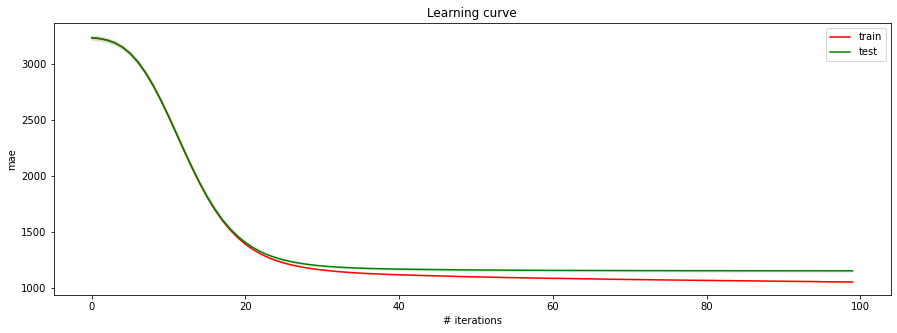

score:                                                                                                                                  
1153.6154082058672                                                                                                                      
2.6369446158810033                                                                                                                      
{'max_depth': 14, 'colsample_bytree': 0.8551888194636588, 'learning_rate': 0.12476165081748222, 'subsample': 0.968748473826041, 'seed': 2019, 'min_child_weight': 90, 'reg_alpha': 1.0657468559210397, 'reg_lambda': 0.7644430102971828, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 93%|████████████████████████████████████████████████████████████▋    | 28/30 [45:01<03:45, 112.96s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:48, 48.72s/it]

2it [01:42, 51.99s/it]

3it [02:24, 47.08s/it]

3it [02:24, 48.08s/it]


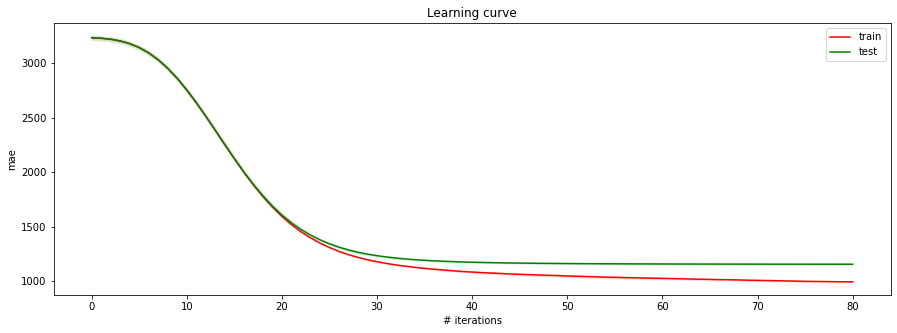

score:                                                                                                                                  
1154.9941863680092                                                                                                                      
1.8530694149638667                                                                                                                      
{'max_depth': 9, 'colsample_bytree': 0.5625422675839674, 'learning_rate': 0.1136875131112226, 'subsample': 0.8199882697888183, 'seed': 2019, 'min_child_weight': 40, 'reg_alpha': 1.2212732873950394, 'reg_lambda': 0.9408177610016307, 'n_estimators': 100, 'objective': 'reg:squarederror'}
 97%|██████████████████████████████████████████████████████████████▊  | 29/30 [47:26<02:02, 122.47s/trial, best loss: 1151.785072761544]

0it [00:00, ?it/s]

1it [00:26, 26.03s/it]

2it [00:52, 26.05s/it]

3it [01:17, 25.96s/it]

3it [01:17, 25.99s/it]


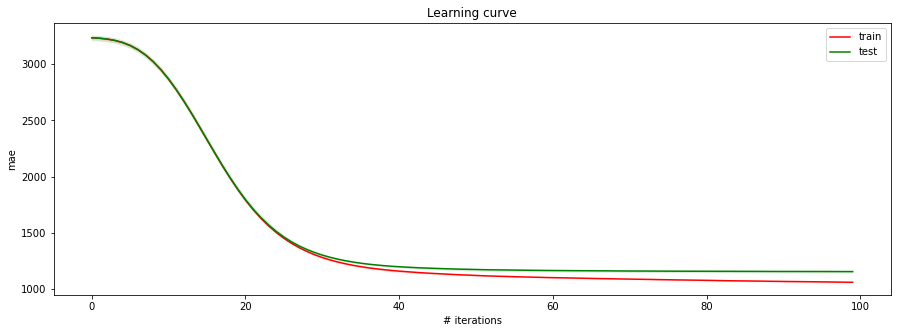

score:                                                                                                                                  
1155.5575073388852                                                                                                                      
2.5813866219531554                                                                                                                      
100%|██████████████████████████████████████████████████████████████████| 30/30 [48:44<00:00, 97.49s/trial, best loss: 1151.785072761544]
The best params:  {'x_colsample_bytree': 0.5698926267170993, 'x_learning_rate': 0.09381880383807083, 'x_max_depth': 16.0, 'x_min_child_weight': 180.0, 'x_reg_alpha': 1.0357884319900101, 'x_reg_lambda': 0.9967490968577811, 'x_seed': 3200.0, 'x_shift': 19.0, 'x_subsample': 0.9242412145080963}
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs


In [41]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': 2019, #int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror',
    }
    
    print(xgb_params)
    
    feats = num_feats + cat_id_feats + sum_feats + minus_feats + sqrt_cont_feats + log_cont_feats
    mean_score, std_score = cv_xgb(train, feats, xgb_params, shift=200, plot_lc=True)
    
    print("score:", mean_score, std_score)
    
    return{'loss':mean_score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.2, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.6, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 10, 200, 10),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
    'shift': hp.quniform ('x_shift', 1, 200, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)
%time

In [42]:
trials.best_trial

{'state': 2,
 'tid': 11,
 'spec': None,
 'result': {'loss': 1151.785072761544, 'status': 'ok'},
 'misc': {'tid': 11,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [11],
   'x_learning_rate': [11],
   'x_max_depth': [11],
   'x_min_child_weight': [11],
   'x_reg_alpha': [11],
   'x_reg_lambda': [11],
   'x_seed': [11],
   'x_shift': [11],
   'x_subsample': [11]},
  'vals': {'x_colsample_bytree': [0.5698926267170993],
   'x_learning_rate': [0.09381880383807083],
   'x_max_depth': [16.0],
   'x_min_child_weight': [180.0],
   'x_reg_alpha': [1.0357884319900101],
   'x_reg_lambda': [0.9967490968577811],
   'x_seed': [3200.0],
   'x_shift': [19.0],
   'x_subsample': [0.9242412145080963]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 9, 3, 11, 56, 32, 429000),
 'refresh_time': datetime.datetime(2022, 9, 3, 11, 58, 30, 383000)}

## Przydatne linki:
1. [Webinar - predykcja wysokości odszkodowania](https://bit.ly/3agNnvi)
2. [Exploratory study on ML algorithms
](https://bit.ly/3aiwPmU)
3. [Allstate Claims Severity Competition, 2nd Place Winner's Interview: Alexey Noskov](https://bit.ly/3dqe2bh)
4. [Using your brain for smart transformations of Data](https://bit.ly/3ajTdft)